# Time Series Analysis for GSK, Pfizer and AstraZeneca using ARIMA

In [1]:
# Project 2      
#importing libraries 
import pandas as pd
import numpy as np
import seaborn as sns 
import datetime as dt
import plotly.express as px
import os
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import hvplot.pandas
from pandas_datareader import data as wb

In [2]:
# print(f"Current Working Directory: {Path.cwd()}")

In [3]:
pd.core.common.is_list_like = pd.api.types.is_list_like
stocks = ['GSK', 'PFE', 'AZN']
start = dt.datetime(2018,1,1)
end = dt.datetime.today()    
df = wb.DataReader(stocks, 'yahoo',start,end)
df = df[["Volume","Adj Close"]]
# print(df.head())
# # Save the stock data a csv file
df.to_csv("../Data/df.csv")
df.tail()

Attributes     Volume                         Adj Close                      
Symbols           GSK         PFE        AZN        GSK        PFE        AZN
Date                                                                         
2020-09-22  3299300.0  21562900.0  3878600.0  38.000000  36.250000  55.439999
2020-09-23  3331700.0  21918900.0  2922900.0  37.790001  36.000000  55.660000
2020-09-24  3502900.0  19791200.0  4123700.0  37.380001  35.759998  54.169998
2020-09-25  3275200.0  13621100.0  4954900.0  37.799999  36.049999  55.509998
2020-09-28  3008022.0  13883750.0  2741362.0  37.860001  36.389999  54.750000

In [4]:
# Check Data Types, count of each column and checking nulls in the DataFrame
df.dtypes, df.count(), df.isnull().sum()

(Attributes  Symbols
 Volume      GSK        float64
             PFE        float64
             AZN        float64
 Adj Close   GSK        float64
             PFE        float64
             AZN        float64
 dtype: object,
 Attributes  Symbols
 Volume      GSK        690
             PFE        690
             AZN        690
 Adj Close   GSK        690
             PFE        690
             AZN        690
 dtype: int64,
 Attributes  Symbols
 Volume      GSK        0
             PFE        0
             AZN        0
 Adj Close   GSK        0
             PFE        0
             AZN        0
 dtype: int64)

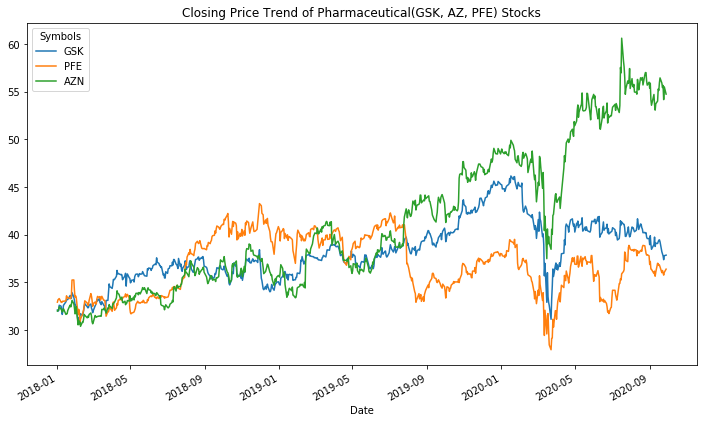

In [5]:
# Plot just the "Adj Close" column from the dataframe:
df["Adj Close"].plot(title = "Closing Price Trend of Pharmaceutical(GSK, AZ, PFE) Stocks", figsize=(12,7), legend = True)

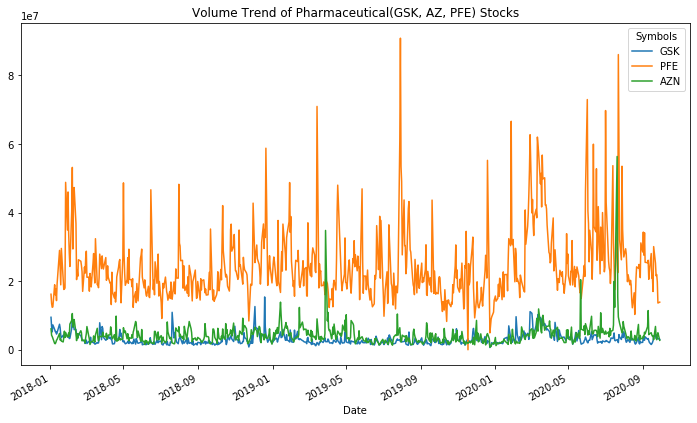

In [6]:
# Plot just the "Adj Close" column from the dataframe:
df["Volume"].plot(title = "Volume Trend of Pharmaceutical(GSK, AZ, PFE) Stocks", figsize=(12,7), legend = True)

## Splitting the data into individual datasets

In [7]:
# Load the closing prices 
df = pd.read_csv(Path('../Data/df.csv')).drop([1])
# df1 = pd.read_csv(Path('../Data/df.csv')).drop([0,1])
df.head(3)

,Attributes,Volume,Volume.1,Volume.2,Adj Close,Adj Close.1,Adj Close.2
0,Symbols,GSK,PFE,AZN,GSK,PFE,AZN
2,2018-01-02,9465500.0,16185800.0,6107400.0,32.10053253173828,32.92734146118164,31.99385643005371
3,2018-01-03,6600800.0,13456500.0,4195400.0,31.978849411010742,33.171302795410156,32.057151794433594


In [8]:
# # Method 2 of converting the data into desired format
# df2 = df1
# df2["Date"]= pd.to_datetime(df2["Attributes"])
# df2[["GSK_Volume", "PFE_Volume","AZN_Volume", "GSK_Adj_Close", "PFE_Adj_Close", "AZN_Adj_Close"]] = df2[["Volume", "Volume.1", "Volume.2", "Adj Close", "Adj Close.1", "Adj Close.2"]].astype(float)
# df2= df2[["Date", "GSK_Volume", "PFE_Volume","AZN_Volume", "GSK_Adj_Close", "PFE_Adj_Close", "AZN_Adj_Close"]]
# df2.head()

In [9]:
# df2.dtypes

In [10]:
def construct_df(df, volume, adj_close):
    r_df = pd.DataFrame({"Volume": df[volume], "Adj Close": df[adj_close],
                      "Date": df["Attributes"]})
    r_df.drop([0], inplace=True)
    r_df["Volume"] = r_df["Volume"].astype(float)
    r_df["Adj Close"] = r_df["Adj Close"].astype(float)
    r_df["Date"] = pd.to_datetime(r_df["Date"])
    r_df.drop(r_df.loc[r_df["Date"] <'2020-01-01'].index, inplace=True)
    r_df = r_df.set_index("Date")
    return r_df

In [11]:
# extract data for GSK and create a dataframe for GSK/Pfizer, AZ
gsk_df = construct_df(df, "Volume","Adj Close")
pfe_df = construct_df(df, "Volume.1","Adj Close.1")
azn_df = construct_df(df, "Volume.2","Adj Close.2")
# Data Checks
gsk_df.head(2), gsk_df.dtypes, pfe_df.head(2), pfe_df.dtypes, azn_df.head(2), azn_df.dtypes

(               Volume  Adj Close
 Date                            
 2020-01-02  2462400.0  45.229774
 2020-01-03  2149100.0  44.805626,
 Volume       float64
 Adj Close    float64
 dtype: object,
                 Volume  Adj Close
 Date                             
 2020-01-02  15668000.0  37.990608
 2020-01-03  14158300.0  37.786774,
 Volume       float64
 Adj Close    float64
 dtype: object,
                Volume  Adj Close
 Date                            
 2020-01-02  3587300.0  48.992023
 2020-01-03  1208700.0  48.700348,
 Volume       float64
 Adj Close    float64
 dtype: object)

# Decomposition Using a Hodrick-Prescott Filter

Using a Hodrick-Prescott Filter, decompose the closing price into a trend and noise.

In [12]:
# Trim the datasets to have data until 9 July 2020 (70%: 30% split)
gsk_df = gsk_df.loc['2020-1-1':'2020-7-09']
pfe_df = pfe_df.loc['2020-1-1':'2020-7-09']
azn_df = azn_df.loc['2020-1-1':'2020-7-09']
# Data Checks
gsk_df.tail(), pfe_df.tail(), azn_df.tail()

(               Volume  Adj Close
 Date                            
 2020-07-02  2713900.0  40.739948
 2020-07-06  2162800.0  40.532391
 2020-07-07  2064900.0  39.909733
 2020-07-08  2253800.0  40.255653
 2020-07-09  2770600.0  39.899845,
                 Volume  Adj Close
 Date                             
 2020-07-02  42951500.0  34.175972
 2020-07-06  25759900.0  34.175972
 2020-07-07  23859600.0  33.700619
 2020-07-08  23013800.0  33.423332
 2020-07-09  19320400.0  33.136139,
                Volume  Adj Close
 Date                            
 2020-07-02  4591300.0  53.373314
 2020-07-06  5180900.0  53.670937
 2020-07-07  3747500.0  53.045933
 2020-07-08  6247800.0  53.760220
 2020-07-09  4203000.0  53.541969)

In [13]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Adj Close" into two separate series:
ts_noise_gsk, ts_trend_gsk = sm.tsa.filters.hpfilter(gsk_df["Adj Close"])
ts_noise_pfe, ts_trend_pfe = sm.tsa.filters.hpfilter(pfe_df["Adj Close"])
ts_noise_azn, ts_trend_azn = sm.tsa.filters.hpfilter(azn_df["Adj Close"])

In [14]:
# Create dataframes of just the exchange rate price, and add columns for "noise" and "trend" series from above:
gsk_df["ts_noise_gsk"] = ts_noise_gsk
gsk_df["ts_trend_gsk"] = ts_trend_gsk

pfe_df["ts_noise_pfe"] = ts_noise_pfe
pfe_df["ts_trend_pfe"] = ts_trend_pfe

azn_df["ts_noise_azn"] = ts_noise_azn
azn_df["ts_trend_azn"] = ts_trend_azn

gsk_df.reset_index()
pfe_df.reset_index()
azn_df.reset_index()

gsk_df_hpf = gsk_df[["Adj Close", "ts_noise_gsk", "ts_trend_gsk"]]
pfe_df_hpf = pfe_df[["Adj Close", "ts_noise_pfe", "ts_trend_pfe"]]
azn_df_hpf = azn_df[["Adj Close", "ts_noise_azn", "ts_trend_azn"]]
# Data Sample Checks
gsk_df_hpf.tail(), pfe_df_hpf.tail(), azn_df_hpf.tail()

(            Adj Close  ts_noise_gsk  ts_trend_gsk
 Date                                             
 2020-07-02  40.739948      0.434126     40.305822
 2020-07-06  40.532391      0.270430     40.261961
 2020-07-07  39.909733     -0.307850     40.217583
 2020-07-08  40.255653      0.082683     40.172971
 2020-07-09  39.899845     -0.228371     40.128216,
             Adj Close  ts_noise_pfe  ts_trend_pfe
 Date                                             
 2020-07-02  34.175972      1.324511     32.851461
 2020-07-06  34.175972      1.330408     32.845564
 2020-07-07  33.700619      0.859120     32.841499
 2020-07-08  33.423332      0.585156     32.838176
 2020-07-09  33.136139      0.301097     32.835042,
             Adj Close  ts_noise_azn  ts_trend_azn
 Date                                             
 2020-07-02  53.373314      0.394014     52.979300
 2020-07-06  53.670937      0.641027     53.029909
 2020-07-07  53.045933     -0.036009     53.081942
 2020-07-08  53.760220      0

In [15]:
# Data Checks
gsk_df_hpf.dtypes, pfe_df_hpf.dtypes, azn_df_hpf.dtypes

(Adj Close       float64
 ts_noise_gsk    float64
 ts_trend_gsk    float64
 dtype: object,
 Adj Close       float64
 ts_noise_pfe    float64
 ts_trend_pfe    float64
 dtype: object,
 Adj Close       float64
 ts_noise_azn    float64
 ts_trend_azn    float64
 dtype: object)

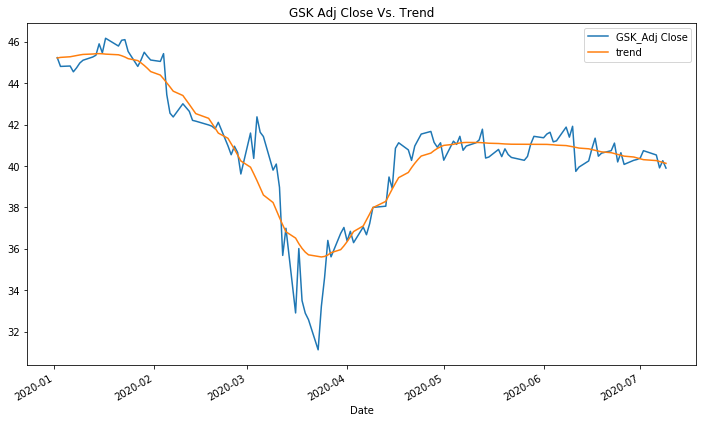

In [16]:
# Plot the GSK_Adj Close vs. the Trend from Jan to June 2020
gsk_df_hpf["Adj Close"].plot(label = 'GSK_Adj Close', figsize=(10,6),legend = True)
gsk_df_hpf.ts_trend_gsk.plot(label = 'trend', title='GSK Adj Close Vs. Trend', figsize=(12,7),legend = True);

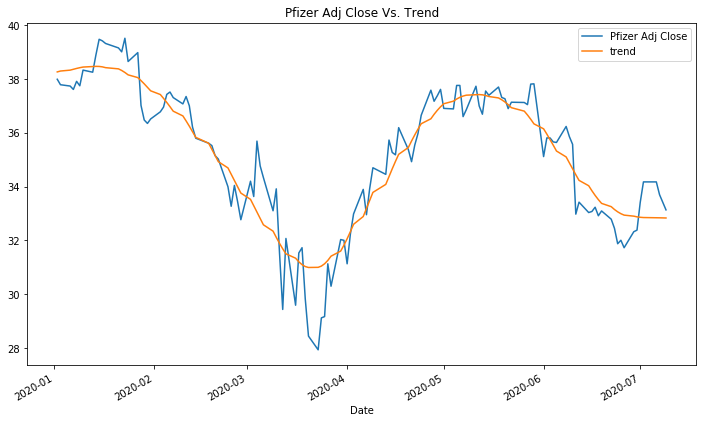

In [17]:
# Plot the PFE_Adj Close vs. the Trend from Jan to June 2020
pfe_df_hpf["Adj Close"].plot(label = 'Pfizer Adj Close', figsize=(10,6),legend = True)
pfe_df_hpf.ts_trend_pfe.plot(label = 'trend', title='Pfizer Adj Close Vs. Trend', figsize=(12,7),legend = True);

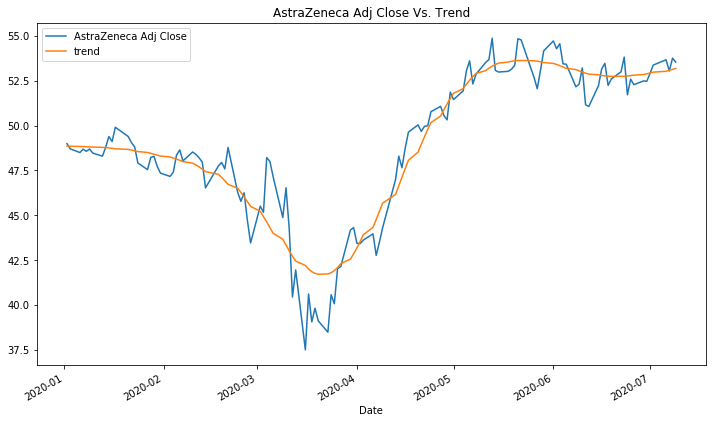

In [18]:
# Plot the AstraZenca Adj Close vs. the Trend from Jan to June 2020
azn_df_hpf["Adj Close"].plot(label = 'AstraZeneca Adj Close', figsize=(10,6),legend = True)
azn_df_hpf.ts_trend_azn.plot(label = 'trend', title='AstraZeneca Adj Close Vs. Trend', figsize=(12,7),legend = True);

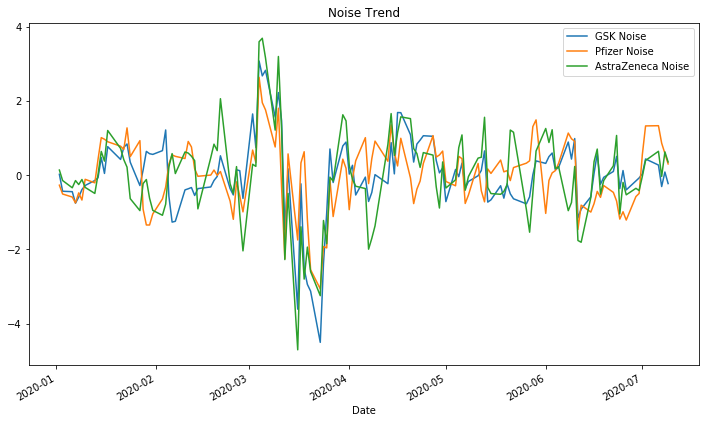

In [19]:
# Plot the GSK/Pfizer/AstraZeneca Price Noise
gsk_df_hpf.ts_noise_gsk.plot(label = 'GSK Noise', figsize=(12,7), legend = True);
pfe_df_hpf.ts_noise_pfe.plot(label = 'Pfizer Noise', figsize=(12,7), legend = True);
azn_df_hpf.ts_noise_azn.plot(label = 'AstraZeneca Noise', title='Noise Trend', figsize=(12,7), legend = True);

## Autocorrelation & Partial Autocorrelation Analysis

Use the autocorrelation and partial autocorrelation data to get a sense of how many lags to use in the ARMA/ARIMA/GARCH models

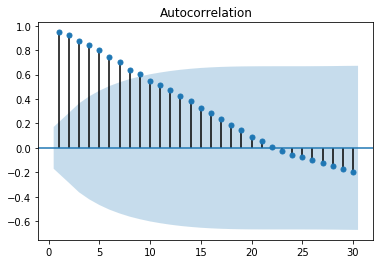

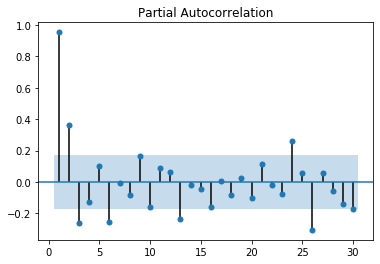

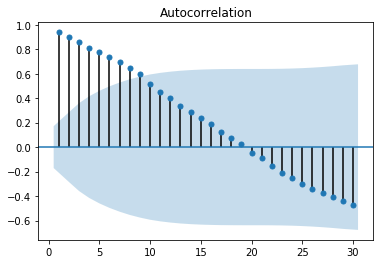

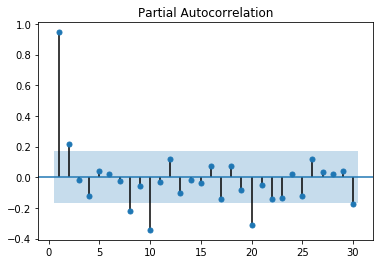

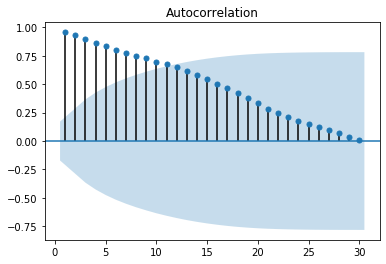

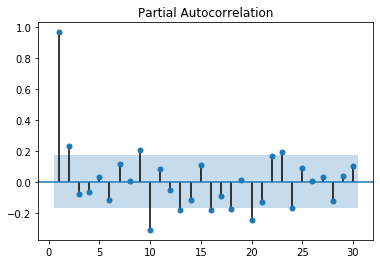

In [20]:
# Import ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(gsk_df['Adj Close'], lags=30, zero=False)
plot_pacf(gsk_df['Adj Close'], lags=30, zero=False);

plot_acf(pfe_df['Adj Close'], lags=30, zero=False)
plot_pacf(pfe_df['Adj Close'], lags=30, zero=False);

plot_acf(azn_df['Adj Close'], lags=30, zero=False)
plot_pacf(azn_df['Adj Close'], lags=30, zero=False);

ACF plot is a bar chart of coefficients of correlation between a time series and it lagged values. Basically, how well the present value of the series is related to its past values. While, PACF is the partial autocorrelation function that explains the partial correlation between the series and lags of itself.

Both ACF and PACF can be used to identify the orders of AR and MA terms in the ARMA model.

From the above ACF plot we notice that 10 lags could potentialy useful while PACF is significant at the 5 lags are outside the default confidence interval of 95%. Hence, we will use use p=8 and q=7 to create the ARIMA model.

# Forecasting GSK Returns using an ARIMA Model

 1. Using the *raw* & "percent change" of the GSK Adj Close, estimate an ARIMA model.
     1. Set P=8, D=1, and Q=7 in the model (e.g., ARIMA(df, order=(8,1,7))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 3 months forecast for the GSK 'Adj Close'. What does the model forecast will happen to the Japanese Yen in the near term?

In [21]:
from statsmodels.tsa.arima_model import ARIMA
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(gsk_df['Adj Close'], order=(2, 1, 2))
# Fit the model
results = model.fit()
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  130
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -157.354
Method:                       css-mle   S.D. of innovations              0.810
Date:                Mon, 28 Sep 2020   AIC                            326.707
Time:                        20:23:24   BIC                            343.913
Sample:                             1   HQIC                           333.698
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0391      0.070     -0.561      0.575      -0.176       0.097
ar.L1.D.Adj Close    -0.8099      0.143     -5.675      0.000      -1.090      -0.530
ar.L2.D.Adj Close    -0.4948      0.220     -2.245      0.025      -0.927      -0.063
ma.L1.D.Adj Close     0.5696      0.138      4.141      0.000       0.300       0.839
ma.L2.D.Adj Close     0.6927      0.217      3.195      0.001       0.268       1.118
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8183           -1.1624j            1.4216           -0.3476
AR.2           -0.8183           +1.1624j            1.4216            0.3476
MA.1           -0.4111           -1.1290j            1.2015           -0.3056
MA.2           -0.4111           +1.1290j            1.2015            0.3056
-----------------------------------------------------------------------------
"""

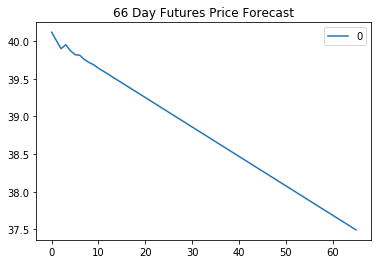

In [22]:
# Plot the 3 months Day Price Forecast
pd.DataFrame(results.forecast(steps=66)[0]).plot(title="66 Day Futures Price Forecast")

### ARIMA with pct_change

In [23]:
GSK_returns = (gsk_df[['Adj Close']].pct_change() * 100)
GSK_returns = GSK_returns.replace(-np.inf, np.nan).dropna()
GSK_returns.tail(2)

,Adj Close
Date,
2020-07-08,0.866757
2020-07-09,-0.883872


In [24]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(GSK_returns['Adj Close'], order=(2, 1, 2))
# Fit the model
results = model.fit()
# Output model summary results:
results.summary()
# save model
# results.csv("../Model Results/GSK_ARIMA_PC_model.pkl")
# load model
# loaded = ARIMAResults.load('model.pkl')

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  129
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -289.608
Method:                       css-mle   S.D. of innovations              2.220
Date:                Mon, 28 Sep 2020   AIC                            591.215
Time:                        20:23:25   BIC                            608.374
Sample:                             1   HQIC                           598.187
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0030      0.004      0.779      0.436      -0.004       0.010
ar.L1.D.Adj Close    -1.3556      0.080    -16.951      0.000      -1.512      -1.199
ar.L2.D.Adj Close    -0.3966      0.080     -4.943      0.000      -0.554      -0.239
ma.L1.D.Adj Close  1.013e-08      0.029    3.5e-07      1.000      -0.057       0.057
ma.L2.D.Adj Close    -1.0000      0.029    -34.583      0.000      -1.057      -0.943
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0770           +0.0000j            1.0770            0.5000
AR.2           -2.3410           +0.0000j            2.3410            0.5000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

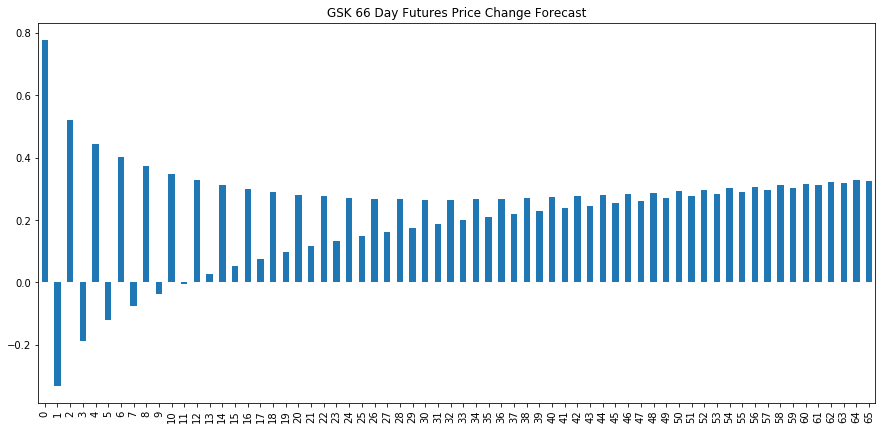

In [25]:
# Plot the 3 months of Closing Price Forecast
pd.DataFrame(results.forecast(steps=66)[0]).plot(kind='bar',title="GSK 66 Day Futures Price Change Forecast",figsize=(15,7),legend = False )

# Forecasting PFizer Returns using an ARIMA Model

In [26]:
model = ARIMA(pfe_df['Adj Close'], order=(2, 1, 2))
# Fit the model
results = model.fit()
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  130
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -161.469
Method:                       css-mle   S.D. of innovations              0.836
Date:                Mon, 28 Sep 2020   AIC                            334.938
Time:                        20:23:28   BIC                            352.143
Sample:                             1   HQIC                           341.929
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0386      0.074     -0.520      0.603      -0.184       0.107
ar.L1.D.Adj Close     0.4051      0.166      2.439      0.015       0.080       0.731
ar.L2.D.Adj Close    -0.6840      0.284     -2.411      0.016      -1.240      -0.128
ma.L1.D.Adj Close    -0.5631      0.093     -6.073      0.000      -0.745      -0.381
ma.L2.D.Adj Close     0.8587      0.233      3.690      0.000       0.403       1.315
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2961           -1.1723j            1.2091           -0.2106
AR.2            0.2961           +1.1723j            1.2091            0.2106
MA.1            0.3279           -1.0281j            1.0792           -0.2009
MA.2            0.3279           +1.0281j            1.0792            0.2009
-----------------------------------------------------------------------------
"""

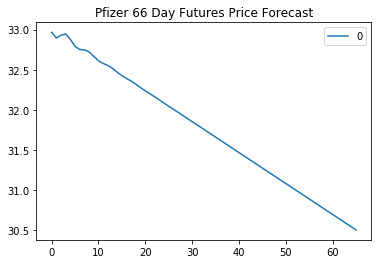

In [27]:
# Plot the 3 months Day Price Forecast
pd.DataFrame(results.forecast(steps=66)[0]).plot(title="Pfizer 66 Day Futures Price Forecast")

### ARIMA with pct_change (Pfizer)

In [28]:
PFE_returns = (pfe_df[['Adj Close']].pct_change() * 100)
PFE_returns = PFE_returns.replace(-np.inf, np.nan).dropna()
PFE_returns.tail()

,Adj Close
Date,
2020-07-02,2.282144
2020-07-06,0.000000
2020-07-07,-1.390899
2020-07-08,-0.822794
2020-07-09,-0.859260


In [29]:
model = ARIMA(PFE_returns['Adj Close'], order=(2, 1, 2))
# Fit the model
results = model.fit()
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  129
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -305.172
Method:                       css-mle   S.D. of innovations              2.522
Date:                Mon, 28 Sep 2020   AIC                            622.343
Time:                        20:23:29   BIC                            639.502
Sample:                             1   HQIC                           629.315
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0009      0.005      0.188      0.851      -0.008       0.010
ar.L1.D.Adj Close    -1.1273      0.110    -10.277      0.000      -1.342      -0.912
ar.L2.D.Adj Close    -0.2841      0.084     -3.387      0.001      -0.449      -0.120
ma.L1.D.Adj Close    -0.1118      0.085     -1.319      0.187      -0.278       0.054
ma.L2.D.Adj Close    -0.8882      0.083    -10.642      0.000      -1.052      -0.725
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3389           +0.0000j            1.3389            0.5000
AR.2           -2.6286           +0.0000j            2.6286            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.1259           +0.0000j            1.1259            0.5000
-----------------------------------------------------------------------------
"""

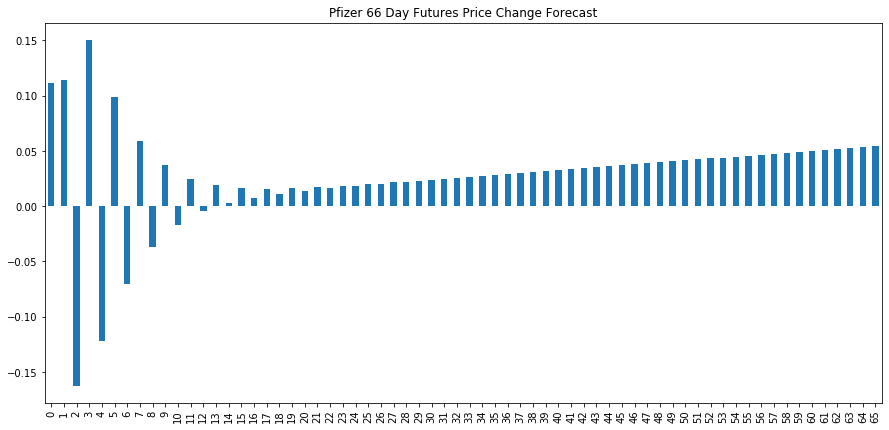

In [30]:
# Plot the 3 months of Closing Price Forecast
pd.DataFrame(results.forecast(steps=66)[0]).plot(kind='bar',title="Pfizer 66 Day Futures Price Change Forecast",figsize=(15,7),legend = False )

# Forecasting AstraZeneca Returns using an ARIMA Model

In [31]:
model = ARIMA(azn_df['Adj Close'], order=(2, 1, 2))
# Fit the model
results = model.fit()
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  130
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -193.804
Method:                       css-mle   S.D. of innovations              1.073
Date:                Mon, 28 Sep 2020   AIC                            399.609
Time:                        20:23:30   BIC                            416.814
Sample:                             1   HQIC                           406.600
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0350      0.084      0.415      0.678      -0.130       0.200
ar.L1.D.Adj Close    -1.6861      0.135    -12.530      0.000      -1.950      -1.422
ar.L2.D.Adj Close    -0.7980      0.139     -5.725      0.000      -1.071      -0.525
ma.L1.D.Adj Close     1.5233      0.180      8.444      0.000       1.170       1.877
ma.L2.D.Adj Close     0.5995      0.192      3.128      0.002       0.224       0.975
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0565           -0.3701j            1.1195           -0.4464
AR.2           -1.0565           +0.3701j            1.1195            0.4464
MA.1           -1.2704           -0.2324j            1.2915           -0.4712
MA.2           -1.2704           +0.2324j            1.2915            0.4712
-----------------------------------------------------------------------------
"""

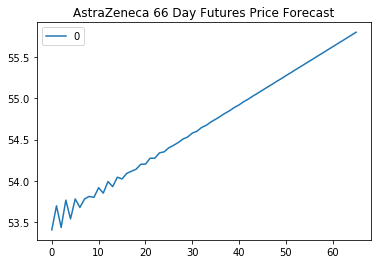

In [32]:
# Plot the 3 months Day Price Forecast
pd.DataFrame(results.forecast(steps=66)[0]).plot(title="AstraZeneca 66 Day Futures Price Forecast")

### ARIMA with pct_change (AstraZeneca)

In [33]:
AZN_returns = (azn_df[['Adj Close']].pct_change() * 100)
AZN_returns = AZN_returns.replace(-np.inf, np.nan).dropna()
AZN_returns.tail()

,Adj Close
Date,
2020-07-02,0.900224
2020-07-06,0.557625
2020-07-07,-1.164511
2020-07-08,1.346544
2020-07-09,-0.405970


In [34]:
model = ARIMA(AZN_returns['Adj Close'], order=(2, 1, 2))
# Fit the model
results = model.fit()
# Output model summary results:
results.summary()

C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anirban\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  129
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -297.034
Method:                       css-mle   S.D. of innovations              2.349
Date:                Mon, 28 Sep 2020   AIC                            606.067
Time:                        20:23:31   BIC                            623.226
Sample:                             1   HQIC                           613.039
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0032      0.004      0.758      0.449      -0.005       0.012
ar.L1.D.Adj Close    -1.2459      0.083    -15.075      0.000      -1.408      -1.084
ar.L2.D.Adj Close    -0.3287      0.084     -3.899      0.000      -0.494      -0.163
ma.L1.D.Adj Close  -6.07e-08      0.020  -3.04e-06      1.000      -0.039       0.039
ma.L2.D.Adj Close    -1.0000      0.020    -50.018      0.000      -1.039      -0.961
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1538           +0.0000j            1.1538            0.5000
AR.2           -2.6369           +0.0000j            2.6369            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

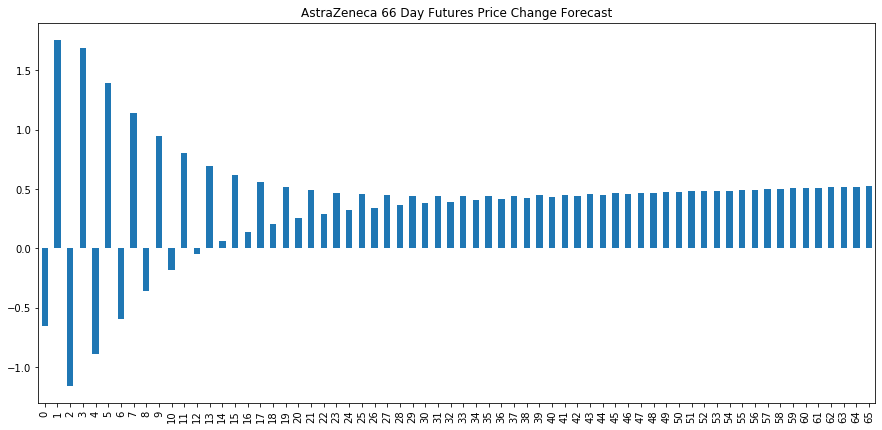

In [35]:
# Plot the 3 months of Closing Price Forecast
pd.DataFrame(results.forecast(steps=66)[0]).plot(kind='bar',title="AstraZeneca 66 Day Futures Price Change Forecast",figsize=(15,7),legend = False )